<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import re


from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from nltk import word_tokenize
stopwords = set(nltk_stopwords.words('english'))
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud

from pymystem3 import Mystem
m = Mystem() 
import transformers

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chern\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chern\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Подготовка

Загрузим и рассмотрим данные:

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv("C:/Users/chern/toxic_comments.csv")

display(df.head(10))
display(df.info())
display(df.shape)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

(159292, 3)

Удалим лишний столбец, дублирующий индексы:

In [3]:
df = df.drop(['Unnamed: 0'], axis=1)

Лемантизируем текст и уберем лишние знаки:

In [4]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

In [5]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
lemmatizer = WordNetLemmatizer()

In [7]:
%%time
def lemmafunction(text):
    k = []
    for i in nltk.word_tokenize(text):
        y = lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 

lemy = []
for i in tqdm(range(len(df.text))):
    
    lemy.append(lemmafunction(clear_text(df.text[i])))
df['text'] = pd.Series(lemy, index=df.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 2h 42min 59s
Wall time: 2h 43min 39s


In [8]:
df_nltk = nltk.Text(df.text)
df_nltk

<Text: explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now d aww he match this background colour i m seemingly stuck with thanks talk january utc hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format than the actual info more i can t make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i g

In [9]:
fdist = FreqDist(df_nltk)
fdist.most_common(5)

[('january', 21),
 ('thank you for experiment with wikipedia your test work and it have be revert or remove please use the sandbox for any other test you may want to do take a look at the welcome page to learn more about contribute to our encyclopedia talk',
  19),
 ('jun utc', 18),
 ('please stop if you continue to vandalize page you will be block from edit wikipedia',
  18),
 ('precede unsigned comment add by', 16)]

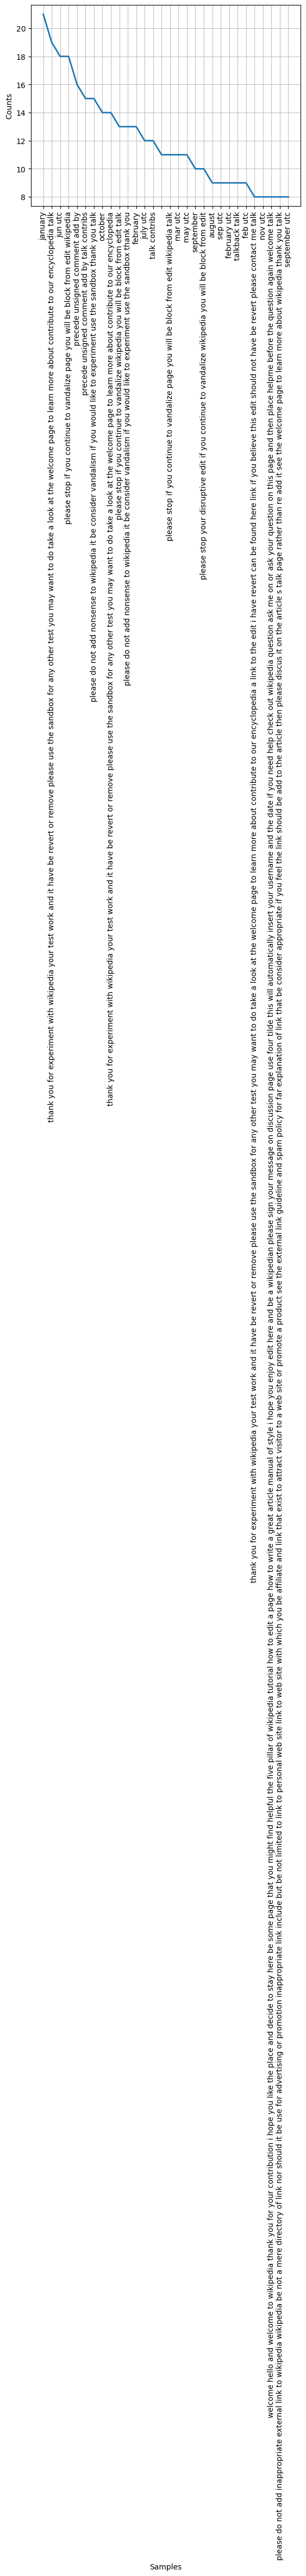

In [10]:
fdist.plot(30,cumulative=False);

In [11]:
#cloud = str(df.text, encoding='utf-8', errors='errors')

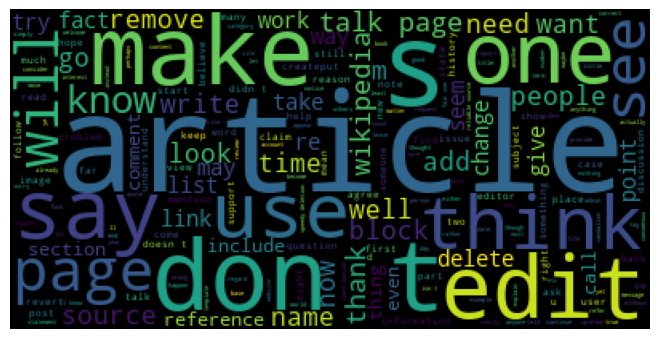

In [12]:
plt.imshow(WordCloud().generate(' '.join(df.text)))
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Разделим данные на признаки и целевой признак, а также на обучающую и тестовую выборки в соотношении 75:25

In [13]:
features = df.drop(['toxic'], axis=1) 
target = df.toxic

In [14]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=0
)

display(features_train, features_test, target_train, target_test)

,text
25283,your advice please we put elmo tanner up for g...
12729,it be possible to have a bias opinion and writ...
149149,kansa watch list i didn t know if you have a l...
60470,welcome hello and welcome to wikipedia thank y...
100052,sir good even i want to say something about an...
...,...
97639,gun powder ma
95939,what volume for whoever note that there be a t...
152315,i agree with wikireader the source iqinn give ...
117952,it have now be a week and a half and not and n...


,text
33703,well since i be block i shall temporarily resp...
86675,hahahahaha typical the article be about anti p...
47557,which you make after i be encourage by a media...
96900,i regard you a racist i will request you be ba...
66242,a broken chair be not a chair a broken chord b...
...,...
131527,a few comment about some criterion x instead o...
55718,well a soon a i find it cologne be refer by he...
1982,well change it then
136314,it not offical it by some year old kid who hav...


25283     0
12729     0
149149    0
60470     0
100052    0
         ..
97639     0
95939     0
152315    0
117952    0
43567     0
Name: toxic, Length: 119469, dtype: int64

33703     0
86675     0
47557     0
96900     1
66242     0
         ..
131527    0
55718     0
1982      0
136314    0
108647    0
Name: toxic, Length: 39823, dtype: int64

In [15]:
features_train = features_train.text.astype("string")
features_train.shape

(119469,)

Посмотрим на соотношение классов в таргете:

toxic
0    0.898585
1    0.101415
Name: proportion, dtype: float64


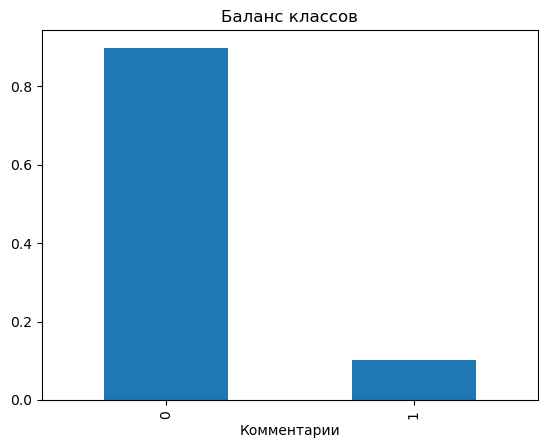

In [16]:
class_frequency = target_train.value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar')
plt.title('Баланс классов')
plt.xlabel('Комментарии')
plt.show();

In [17]:
ratio = len(target_train == 0)//len(target_train == 1)
ratio

1

Так как, наблюдается сильный дисбаланс классов, проведем ресемплирование уменьшением выборки - уменьшим размер класса "0"

In [20]:
display(features_train.shape, target_train.shape)

(119469,)

(119469,)

In [21]:
display(features_train, target_train)

25283     your advice please we put elmo tanner up for g...
12729     it be possible to have a bias opinion and writ...
149149    kansa watch list i didn t know if you have a l...
60470     welcome hello and welcome to wikipedia thank y...
100052    sir good even i want to say something about an...
                                ...                        
97639                                         gun powder ma
95939     what volume for whoever note that there be a t...
152315    i agree with wikireader the source iqinn give ...
117952    it have now be a week and a half and not and n...
43567     well let s go through this one by one we shoul...
Name: text, Length: 119469, dtype: string

25283     0
12729     0
149149    0
60470     0
100052    0
         ..
97639     0
95939     0
152315    0
117952    0
43567     0
Name: toxic, Length: 119469, dtype: int64

**Вывод:**
- Данные состоят из 3 столбцов и 159292 строк.
- Удалили лишний столбец, дублирующий индексы.
- Обработели текст: провели лемантизацию и очистку текста.
- Разделили данные на признаки и целевой признак, а также на обучающую и тестовую выборки в соотношении 75:25.
- Проверили баланс классов и обнаружили сильный дисбаланс: 90:10%

## Обучение

Обучим данные на модели Дерево решений:

In [22]:
%%time

pipeline_dtc = Pipeline([("vector", TfidfVectorizer(stop_words='english')), 
                     ("dtc", DecisionTreeClassifier())])

parameters_dtc = {'dtc__max_depth': ([x for x in range(1, 10)]),
                  'dtc__random_state': ([12345]), 
                  'dtc__class_weight': (['balanced'])}

grid_search_dtc = GridSearchCV(pipeline_dtc, param_grid=parameters_dtc, cv=3, scoring='f1')
grid_search_dtc.fit(features_train, target_train)

best_parametrs_dtc = grid_search_dtc.best_params_
best_score_dtc = 1 * grid_search_dtc.best_score_

print("Лучшее значение глубины:", best_parametrs_dtc)
print("Лучшая оценка кросс-валидации:", best_score_dtc)

Лучшее значение глубины: {'dtc__class_weight': 'balanced', 'dtc__max_depth': 9, 'dtc__random_state': 12345}
Лучшая оценка кросс-валидации: 0.5711270913436571
CPU times: total: 5min 17s
Wall time: 5min 19s


Обучим данные на модели Логистическая регрессия:

In [23]:
%%time

pipeline_lr = Pipeline([("vector", TfidfVectorizer(stop_words='english', sublinear_tf=True)), 
                     ("lr", LogisticRegression())])

parameters_lr = {'lr__random_state': ([12345]), 
                 'lr__class_weight': (['balanced']),
                 'lr__C': ([0.1, 1, 10])}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid=parameters_lr, cv=3, scoring='f1')
grid_search_lr.fit(features_train, target_train)

best_parametrs_lr = grid_search_lr.best_params_
best_score_lr = 1 * grid_search_lr.best_score_

print("Лучшее значение глубины:", best_parametrs_lr)
print("Лучшая оценка кросс-валидации:", best_score_lr)

Лучшее значение глубины: {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__random_state': 12345}
Лучшая оценка кросс-валидации: 0.7600818976158735
CPU times: total: 2min 15s
Wall time: 1min 23s


Обучим данные на модели CatBoost:

In [24]:
%%time

pipeline_cbc = Pipeline([("vector", TfidfVectorizer(stop_words='english')), 
                     ("cbc", CatBoostClassifier())])

parameters_cbc = {'cbc__random_state': ([12345]),
                  'cbc__verbose': ([False]),
                  'cbc__class_weights': ([(1, 1), (1, 11)])}

grid_search_cbc = GridSearchCV(pipeline_cbc, param_grid=parameters_cbc, cv=3, scoring='f1')
grid_search_cbc.fit(features_train, target_train)

best_parametrs_cbc = grid_search_cbc.best_params_
best_score_cbc = 1 * grid_search_cbc.best_score_

print("Лучшее значение глубины:", best_parametrs_cbc)
print("Лучшая оценка кросс-валидации:", best_score_cbc)

Лучшее значение глубины: {'cbc__class_weights': (1, 1), 'cbc__random_state': 12345, 'cbc__verbose': False}
Лучшая оценка кросс-валидации: 0.7424463811791782
CPU times: total: 9h 45min 48s
Wall time: 1h 58min 9s


Протестируем лучшую модель:

In [25]:
features_test = features_test.text.astype("string")
features_test.shape

(39823,)

In [26]:
predict_t = grid_search_lr.predict(features_test)
predict_t

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [27]:
result = f1_score(target_test, predict_t)

result

0.7637481498349082

Проверим адекватность лучшей модели на константной модели:

In [28]:
model = DummyClassifier(strategy='constant', constant = 1)
model.fit(features_train, target_train)

predictions_DR = model.predict(features_test)
result = f1_score(target_test, predictions_DR)

result

0.18545098307247168

## **Вывод:**
- Обучили данные на 3 моделях: Дерево решений, Логистическая регрессия и CatBoost.
- Лучший результат показала Логистическая регрессия со значением f1_score = 0.76.
- Протестировали дучшую можель с результатом f1_score = 0.76
- Проверили модель на адекватность на константной модели. Метрика качества хуже, чем на лучшей модели, следовательно, адекватность модели подтвердилась.

## Выводы

Цель исследования - обучить модель классифицировать комментарии на позитивные и негативные.

1) В результате исследования рассмотрели предоставленные данные и подготовили их к обучению:

- Данные состоят из 3 столбцов и 159292 строк.
- Удалили лишний столбец, дублирующий индексы.
- Обработели текст: провели лемантизацию и очистку текста.
- Разделили данные на признаки и целевой признак, а также на обучающую и тестовую выборки в соотношении 75:25.
- Проверили баланс классов и обнаружили сильный дисбаланс: 90:10%


2) Следующим шагом обучили и протестировали модели:

- Обучили данные на 3 моделях: Дерево решений, Логистическая регрессия и CatBoost.
- Лучший результат показала Логистическая регрессия со значением f1_score = 0.76.
- Протестировали дучшую можель с результатом f1_score = 0.76.
- Проверили модель на адекватность на константной модели. Метрика качества хуже, чем на лучшей модели, следовательно, адекватность модели подтвердилась.